# CNN-lytical Assignment-3
<center>
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS7fZ0PJ4leQi4qtXR5Egv5YILqQqvzVSNtFg&usqp=CAU">
</center>

*  In this assignment, we will use CNNs in [PyTorch](https://pytorch.org/docs/stable/index.html) for image classification.

* We have been using MNIST by flattening 28$\times$28 images to 784-sized vectors.

* This time, we will classify images from the CIFAR-10 dataset - dimension is 32$\times$32.

* Much of this notebook remains the same as for Assignment 2, just minor changes would be needed and this assignment won't take long.

**Feel free to redefine any function signatures below, just make sure the final cell remains the same.**

## Import libraries here
PyTorch, NumPy, Matplotlib, ...
Even when equipped with PyTorch, NumPy and Matplotlib make your work easier for visualization etc.

Note the following method to **initialize the seed** for reproducibility of results, both for NumPy & PyTorch (CPU/CUDA).

In [ ]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    # np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # # When running on the CuDNN backend, two further options must be set
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False
    # # Set a fixed value for the hash seed
    # os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(42)

In [ ]:
import numpy as np
import torch
import torch.nn as nn

## Load *Dataset*
Use the [pickle file](https://drive.google.com/file/d/1_IHICOfAsT7x63VBBuN1WMh4bDqtUThp/view?usp=sharing) shared for this assignment here.

In [ ]:
# load the data set


from google.colab import drive
drive.mount('/content/drive')

import pickle

DATA_PATH = "/content/drive/My Drive"
infile = open(DATA_PATH+'/train_data.pkl','rb')
best_model2 = pickle.load(infile)

import pandas as pd

var=pd.read_pickle('/content/drive/My Drive/train_cifar.pkl')
Y = var['y']
X = var['X']
print(X.shape)

from sklearn import preprocessing

from sklearn.model_selection import train_test_split
StandDev = np.std(X,axis = 0,keepdims = True)
Mean= np.mean(X,axis = 0,keepdims=True)
Normalized_X = (X-Mean)/(StandDev + 1e-7)
Normalized_X = np.reshape(Normalized_X ,(50000,3,32,32))
print(Normalized_X.shape)
testsize = 0.5
X_train, X_test, y_train, y_test = train_test_split(Normalized_X, Y, test_size = testsize,random_state = 42)

# Split into X_train, y_train, X_test, y_test
# you can use stratified splitting from sklearn library



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(50000, 32, 32, 3)
(50000, 3, 32, 32)


ValueError: ignored

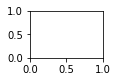

In [ ]:
# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels
import matplotlib.pyplot as plt
import random
for i in range(16):
    plt.subplot(4,4,i+1)
    index=random.randrange(0,50000)
    image = X[index]
    image = np.array(image, dtype='float')
    #pixels = image.reshape((32,32,3))
    #plt.imshow(pixels)


    im_r = image[0:1024].reshape(32, 32,1)
    im_g = image[1024:2048].reshape(32, 32,1)
    im_b = image[2048:].reshape(32, 32,1)

    img = np.dstack((im_r, im_g, im_b))
    plt.title(Y[index][0])
    plt.axis('off')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

## Creating a Dataset Class
In PyTorch, there is existing implementation of batch-splitting. You don't need to do it manually over here. Instead, just define a Dataset class and a Dataloader wrapping it.

A dataset class must have 3 functions - ```__init__```, ```__len__```, ```__getitem__```. Their names are pretty self-explanatory. You can read more about this [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

You will have to perform normalization, augmentation on the dataset here itself, have a look at [PyTorch Transforms](https://pytorch.org/vision/stable/transforms.html).

**Note -** While initializing the dataset class object, make sure you only pass the numpy arrays for images and labels. So the ```__init__``` function should look like
```
    def __init__(self, X, y):
```

In [ ]:
# define your dataset class

import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

class CIFAR_Dataset(Dataset):
  def __init__(self, x, y):
    self.images = x
    self.labels = y

  def __len__(self):
    return len(self.labels)
  
  def __getitem__(self, idx):
    return self.images[idx], self.labels[idx]

from torch.utils.data import DataLoader

train_dataset = CIFAR_Dataset(X_train, y_train)
test_dataset = CIFAR_Dataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size =64, shuffle = True)



## ```nn.Module``` for your model
In this segment, define a class for your model, it has to inherit from the ```nn.Module``` class. You must define two functions here - ```__init__``` and ```forward```, again pretty self-explanatory. Helper functions can also be implemented, your choice!

Look into the following ```torch``` layers beyond those you used in the second assignment and combine them to form your network, you can find more [here](https://pytorch.org/docs/stable/nn.html) -
- [```nn.Conv2d```](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
- [```nn.BatchNorm2d```](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)


In [ ]:
# define a child class of nn.Module for your model
# specify the architecture here itself

import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
device = get_device()

In [ ]:
import torch
print( torch.cuda.is_available())

False


In [ ]:
model = Net().to(device)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## Training loop
You can write a training loop but usually writing it within a function helps so that you can train in multiple passes with just one function call if you still don't see convergence of the loss. ```display_step``` is for you to display results on the validation set (which you must not have trained upon).

You will need to use ```zero_grad()```, ```backward()``` and multiple such functions here. Look for them in the tutorials given.

In [ ]:

def train(model, criterion, optimizer, train_dataloader, epochs):
  for epoch in range(epochs):
    running_loss = 0
    for data in train_dataloader:
      inputs, labels = data[0].to(device), data[1].to(device)
      optimizer.zero_grad()
      outputs = model(inputs.float())
      labels = torch.flatten(labels)
      loss = criterion(outputs, labels.type(torch.LongTensor))
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    print('[Epoch %d] loss: %.3f' % (epoch + 1, running_loss/len(train_dataloader)))
  
  print("training complete")

## Initialize weights
Write a small function to initialize weights for your model. You don't need to do it individually for each layer, there are ways to do it in a simple ```for``` loop.

In [ ]:
def init_weights(...):
    pass

## Prediction & Accuracy
Prediction function should predict outputs using your trained model for a given **NumPy array** ```X_test``` and the output should be another **NumPy array**.

The accuracy function would be the same as before.

In [ ]:

def predict(model, test_dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
    for data in test_dataloader:
      inputs, labels = data[0].to(device), data[1].to(device)
      labels = torch.flatten(labels).type(torch.LongTensor)
      outputs = model(inputs.float())
      _, predicted = torch.max(outputs.data,1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  print('Accuracy of the network on test images: %0.3f %%' % (100 * correct / total))
      #model.eval()

In [ ]:
def accuracy(pred, labels):
     

## Actually training your model
- Create a model, initialize it. Define optimizer for the model as well as loss criterion (you can actually set the seed here again, just in case you did some ```rand``` calls above for testing your functions).
- Define an instance of the dataset class, wrap it in a dataloader.
- Call the train function and train your model!


In [ ]:
train(model,criterion,optimizer,train_dataloader,30)

[Epoch 1] loss: 1.616
[Epoch 2] loss: 1.606
[Epoch 3] loss: 1.598
[Epoch 4] loss: 1.592
[Epoch 5] loss: 1.583
[Epoch 6] loss: 1.573
[Epoch 7] loss: 1.567
[Epoch 8] loss: 1.559
[Epoch 9] loss: 1.552
[Epoch 10] loss: 1.547
[Epoch 11] loss: 1.538
[Epoch 12] loss: 1.530
[Epoch 13] loss: 1.525
[Epoch 14] loss: 1.516
[Epoch 15] loss: 1.508
[Epoch 16] loss: 1.502
[Epoch 17] loss: 1.495
[Epoch 18] loss: 1.489
[Epoch 19] loss: 1.483
[Epoch 20] loss: 1.476
[Epoch 21] loss: 1.470
[Epoch 22] loss: 1.464
[Epoch 23] loss: 1.459
[Epoch 24] loss: 1.454
[Epoch 25] loss: 1.447
[Epoch 26] loss: 1.440
[Epoch 27] loss: 1.436
[Epoch 28] loss: 1.430
[Epoch 29] loss: 1.424
[Epoch 30] loss: 1.423
training complete


## Run your model for the validation dataset
Use your trained model to get predictions for the validation dataset you split earlier.

## Submission
To submit your solution, you will need to make a file with name ```model.py``` containing imports necessary to write the model class and the model class itself. It shouldn't do anything else when run. Also create a file ```dataset.py``` with the dataset class and all necessary imports. Other than this, save the trained model in a file named ```ass_2.pt```. When you are done with the assignment, commit the updated notebook, the ```model.py```, ```dataset.py``` class files and the ```ass_2.pt``` model-weights file to the repository.

In [ ]:
from google.colab import files
torch.save(final_model, 'ass_2.pt')
files.download('ass_2.pt') # download the file from the Colab session for submission

Check if it got saved right!

In [ ]:
# load the model, use predict function
predict(model, test_dataloader)

Accuracy of the network on test images: 39.720 %
